In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pyreadr
import itertools
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from utils.dataloader import train_val_loader, test_loader
import xarray as xr

In [2]:
def corr_func(h, method, r, s):
    if method=="brown":
        res = np.power((h/r),s)
    elif method=="powexp":
        res = np.exp(-np.power((h/r),s))        
    elif method == "whitmat":
        res = np.power(2, float(1-s))/sc.special.gamma(s)*\
              np.power((h/r),2)*sc.special.kv(s, (h/r))
    return res    

In [3]:
def extremal_coefficient(h, method, r, s):
    if method=="brown":
        res = 2*sc.stats.norm.cdf(np.sqrt(corr_func(h, method, r, s))/2,loc = 0, scale = 1)    
    else:
        res = 1+np.sqrt(1-corr_func(h, method, r, s)/2)        
    return res    

In [4]:
def abc_ext_func(h, model, r, s):
    length = len(r)
    abc_ext = 0
    for i in range(length):
        abc_ext += extremal_coefficient(h, model, r[i], s[i])
    abc_ext = abc_ext / length
    return(abc_ext)

In [5]:
def abc_error_function(h, model, r_true, s_true, r, s):
    error = np.power(extremal_coefficient(h, model, r_true, s_true) - abc_ext_func(h, model, r, s),2)
    return error

In [6]:
def get_imse(model, true_params, abc_params):
    r_true, s_true = true_params
    r, s, = abc_params
    error, _ = quad(abc_error_function, 0, 40, args = (model, r_true, s_true, r, s))
    return error

In [7]:
def get_abc_metrics(true_params, abc_params, model):
    abc_array = np.array(abc_params)
    abc_mean = np.transpose(abc_array.mean(axis = 2))
    rmse = np.sqrt(np.mean((np.power(abc_mean - true_params,2)), axis = 0))
    imse_ext = np.mean(np.array([get_imse(model, true_params[i], abc_array[:,i]) for i in range(true_params.shape[0])]))
    
    
    print(f"RMSE: {np.round(rmse,2)}") 
    print(f"Ext - IMSE: {np.round(imse_ext,4)}")

In [8]:
exp = "exp_4"
path = f'../data/{exp}/data/'
model = "brown"
brown_params = pyreadr.read_r(path+model+"_test_params.RData")["test_params"].to_numpy()

path = f'../data/{exp}/results/'

In [9]:
subset = np.arange(0,750,30)
true_params = brown_params[subset]

In [10]:
brown_res = xr.open_dataset(path+model+"_abc_samples_interpolated_n1.nc")

In [11]:
brown_res

<xarray.Dataset>
Dimensions:     (test_sample: 25, abc_samples: 200)
Dimensions without coordinates: test_sample, abc_samples
Data variables:
    Range       (test_sample, abc_samples) float64 ...
    Smoothness  (test_sample, abc_samples) float64 ...
    Distance    (test_sample, abc_samples) float64 ...

In [12]:
#Define abc sample arrays
r = brown_res.Range.to_numpy()
s = brown_res.Smoothness.to_numpy()

In [36]:
# Full grid
get_abc_metrics(true_params, [r,s], model)

RMSE: [1.74 0.55]
Ext - IMSE: 1.1769


In [48]:
#Brown interpolated grid
get_abc_metrics(true_params, [r,s], model)

RMSE: [2.4  0.48]
Ext - IMSE: 0.667


In [60]:
#Powexp full grid
get_abc_metrics(true_params, [r,s], model)

RMSE: [2.88 0.5 ]
Ext - IMSE: 0.0512


In [54]:
#Powexp interpolated grid
get_abc_metrics(true_params, [r,s], model)

RMSE: [3.38 0.48]
Ext - IMSE: 0.0622


In [13]:
#Test with n_each = 25
get_abc_metrics(true_params, [r,s], model)

RMSE: [2.62 0.45]
Ext - IMSE: 0.5918


# Compare

In [41]:
i = 24

In [42]:
x = np.linspace(0,40,400)
model = "brown"
corr_true = extremal_coefficient(x, model, true_params[i,0], true_params[i,1])
corr_abc = abc_ext_func(x, model, r[i], s[i])

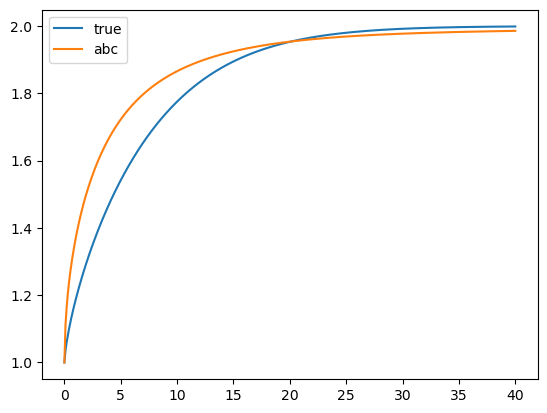

In [43]:
plt.plot(x, corr_true, label = "true")
plt.plot(x, corr_abc, label = "abc")
plt.legend()

In [58]:
np.power(true_params[i,0]-abc_mean[i,0],2)

0.14718798211392928

In [59]:
np.power(true_params[i,1]-abc_mean[i,1],2)

0.005720401835078797